In [2]:
#!pip install h5py

In [9]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
file_path = "MJD_Train_10.hdf5"

✅ Selected Waveforms:
All-True waveform → ID: 2395098
Mostly-False waveform → ID: 2395281


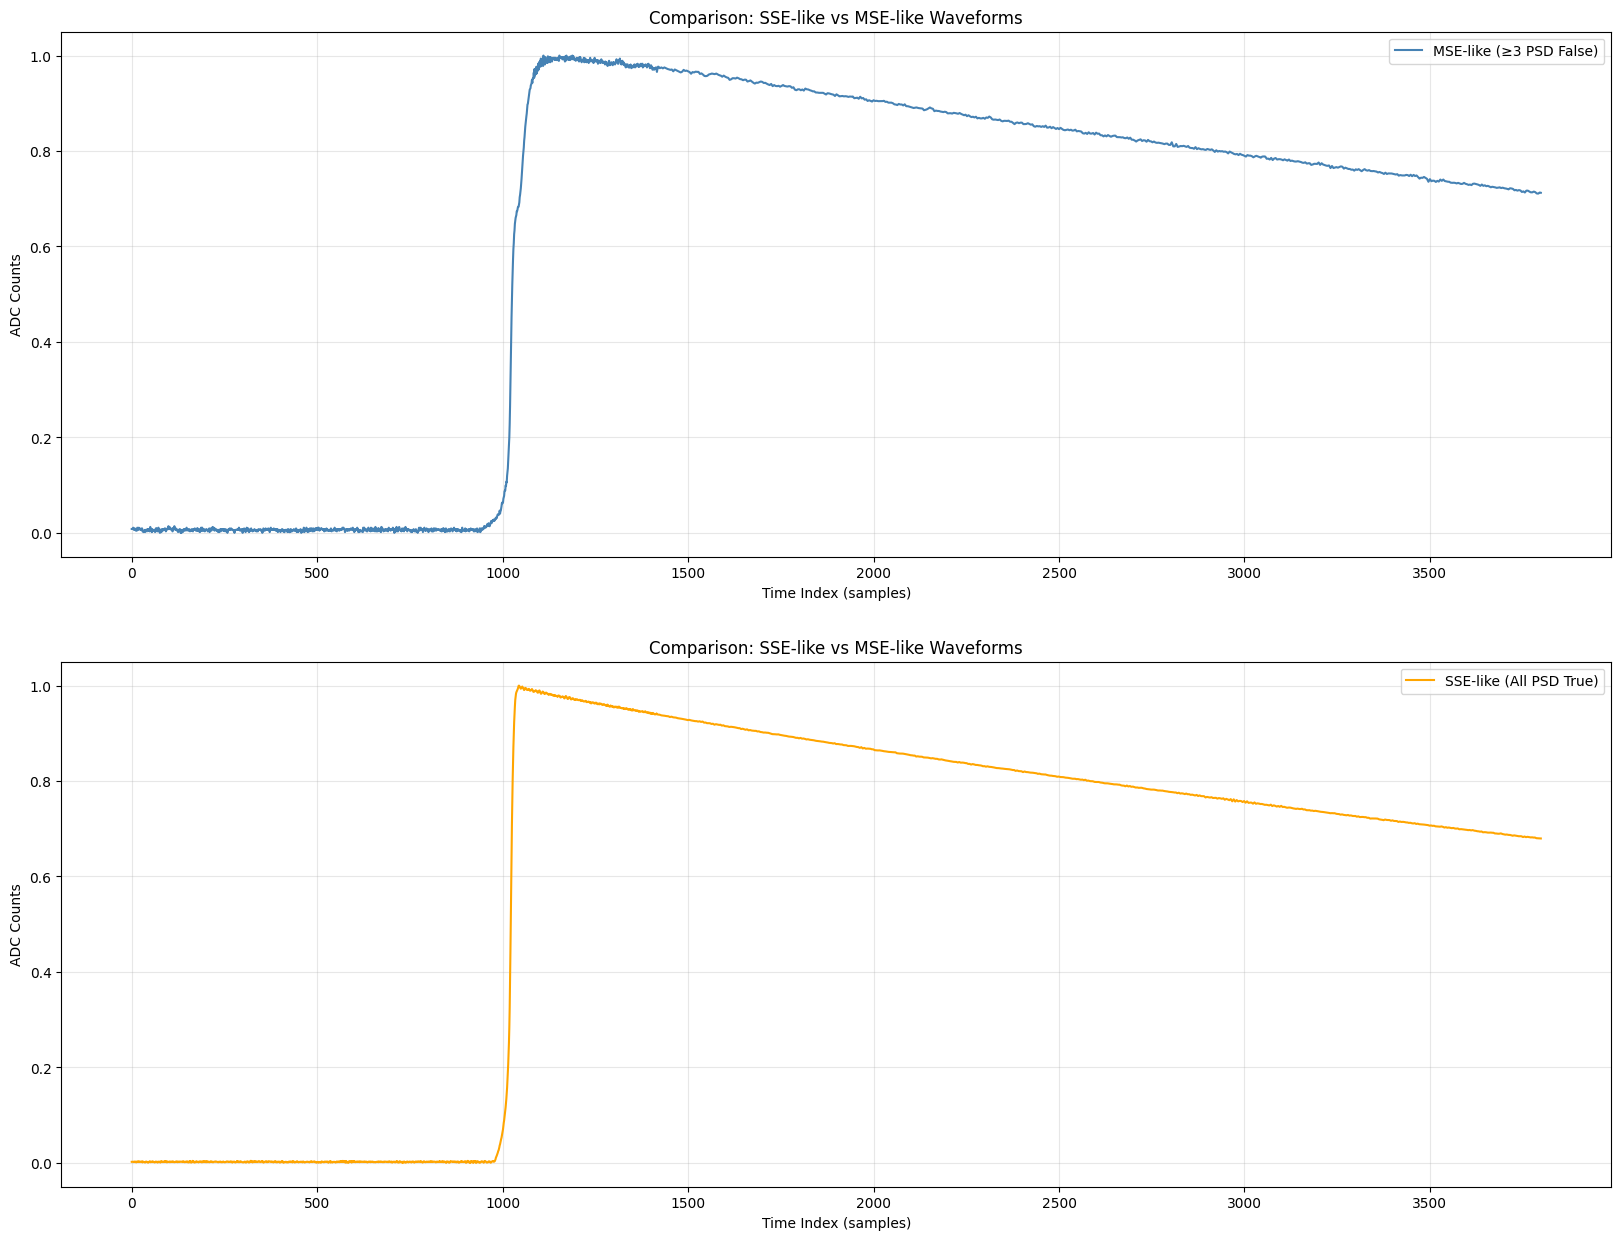

In [65]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_path = "MJD_Test_0.hdf5"

# --- Load waveform and labels ---
with h5py.File(file_path, 'r') as file:
    raw_waveform = np.array(file["raw_waveform"])
    time_index = np.arange(0, raw_waveform.shape[1])

    energy_label = np.array(file["energy_label"])
    psd_label_low_avse = np.array(file["psd_label_low_avse"])
    psd_label_high_avse = np.array(file["psd_label_high_avse"])
    psd_label_dcr = np.array(file["psd_label_dcr"])
    psd_label_lq = np.array(file["psd_label_lq"])
    tp0 = np.array(file["tp0"])
    detector = np.array(file["detector"])
    run_number = np.array(file["run_number"])
    ids = np.array(file["id"])

# --- Combine PSD labels into single array for easier filtering ---
psd_matrix = np.vstack([
    psd_label_low_avse,
    psd_label_high_avse,
    psd_label_dcr,
    psd_label_lq
]).T  # shape (num_waveforms, 4)

# --- Find index where all 4 PSD labels are True ---
all_true_mask = np.all(psd_matrix == True, axis=1)

# --- Find index where at least 3 out of 4 PSD labels are False ---
mostly_false_mask = np.sum(psd_matrix == False, axis=1) >= 3

# --- Select examples ---
if np.any(all_true_mask):
    true_idx = np.where(all_true_mask)[0][0]
else:
    raise ValueError("No waveform found where all PSD labels are True.")

if np.any(mostly_false_mask):
    false_idx = np.where(mostly_false_mask)[0][0]
else:
    raise ValueError("No waveform found where ≥3 PSD labels are False.")

# --- Extract waveforms ---
true_waveform = raw_waveform[true_idx]
false_waveform = raw_waveform[false_idx]

print("✅ Selected Waveforms:")
print(f"All-True waveform → ID: {ids[true_idx]}")
print(f"Mostly-False waveform → ID: {ids[false_idx]}")

wf_norm_sse = (true_waveform - np.min(true_waveform)) / (np.max(true_waveform) - np.min(true_waveform))
wf_norm_mse = (false_waveform - np.min(false_waveform)) / (np.max(false_waveform) - np.min(false_waveform))

# --- Plot both for comparison ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
axes[0].plot(time_index, wf_norm_mse, label='MSE-like (≥3 PSD False)', color='steelblue')
axes[0].set_title("Comparison: SSE-like vs MSE-like Waveforms")
axes[0].set_xlabel("Time Index (samples)")
axes[0].set_ylabel("ADC Counts")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(time_index, wf_norm_sse, label='SSE-like (All PSD True)', color='orange')
axes[1].set_title("Comparison: SSE-like vs MSE-like Waveforms")
axes[1].set_xlabel("Time Index (samples)")
axes[1].set_ylabel("ADC Counts")
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.show()


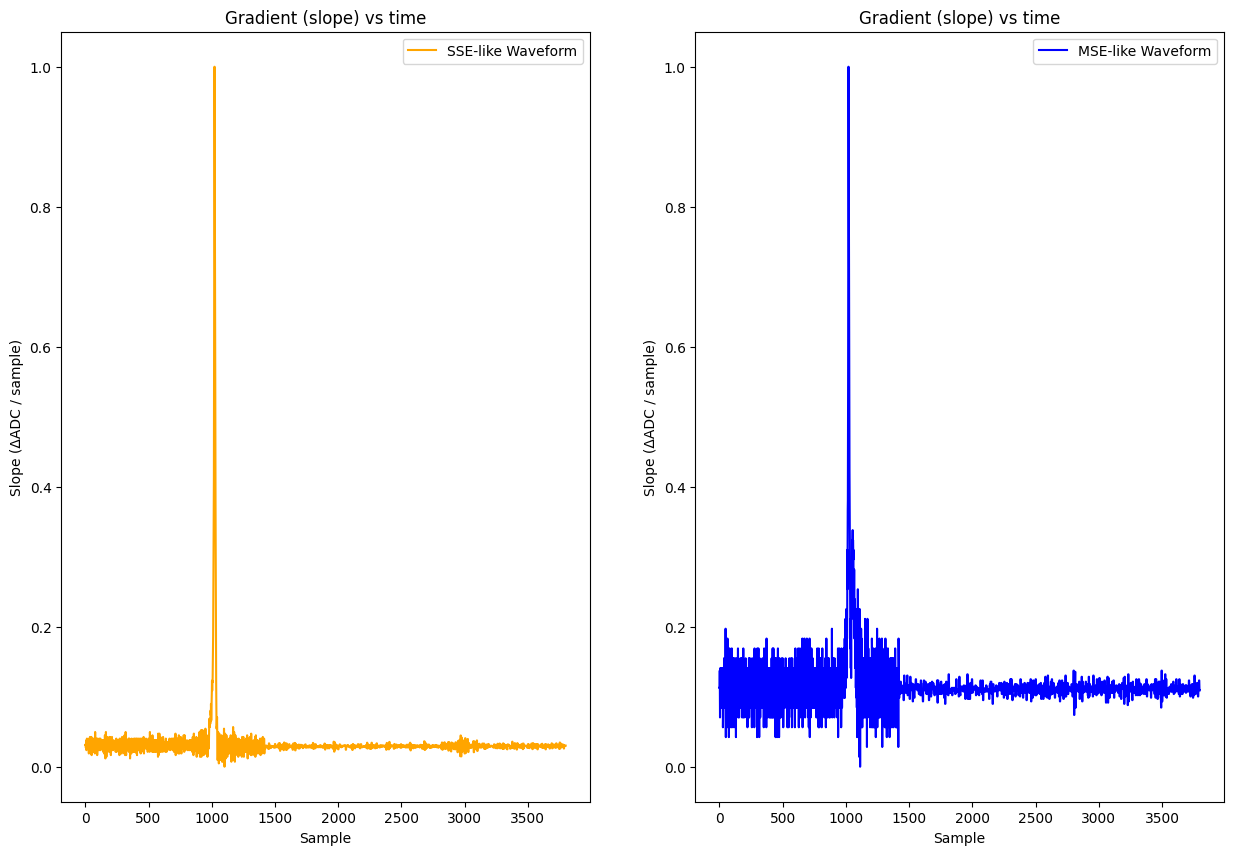

0.005991302111073516
0.027580383742871976


In [67]:
def gradient_trace(wf):
    """
    First difference (slope) as a simple current proxy.
    Returns the slope series and a few summary stats.
    """
    g = np.gradient(wf)
    stats = {
        "max_grad": np.max(g),
        "rms_grad": np.sqrt(np.mean(g**2)),
        "grad_spread": np.percentile(np.abs(g), 95) - np.percentile(np.abs(g), 5)
    }
    return g, stats

def compare_transforms(wf_sse, wf_mse, time_index, smooth_sigma=1.0):
    # ---------- 2) Gradient (slope) ----------
    g_sse, stats_sse = gradient_trace(true_waveform)
    g_mse, stats_mse = gradient_trace(false_waveform)

    wf_norm_sse = (g_sse - np.min(g_sse)) / (np.max(g_sse) - np.min(g_sse))
    wf_norm_mse = (g_mse - np.min(g_mse)) / (np.max(g_mse) - np.min(g_mse))


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10)) # Adjust figsize as needed
    axes[0].plot(time_index, wf_norm_sse, label='SSE-like Waveform', color='orange')    
    axes[0].set_title("Gradient (slope) vs time")
    axes[0].set_xlabel("Sample")
    axes[0].set_ylabel("Slope (ΔADC / sample)")
    axes[0].legend()

    axes[1].plot(time_index, wf_norm_mse, label='MSE-like Waveform', color='blue')
    axes[1].set_title("Gradient (slope) vs time")
    axes[1].set_xlabel("Sample")
    axes[1].set_ylabel("Slope (ΔADC / sample)")
    axes[1].legend()
    plt.show()

    print(wf_norm_sse[:900].std())
    print(wf_norm_mse[:900].std())

compare_transforms(true_waveform, false_waveform, time_index)

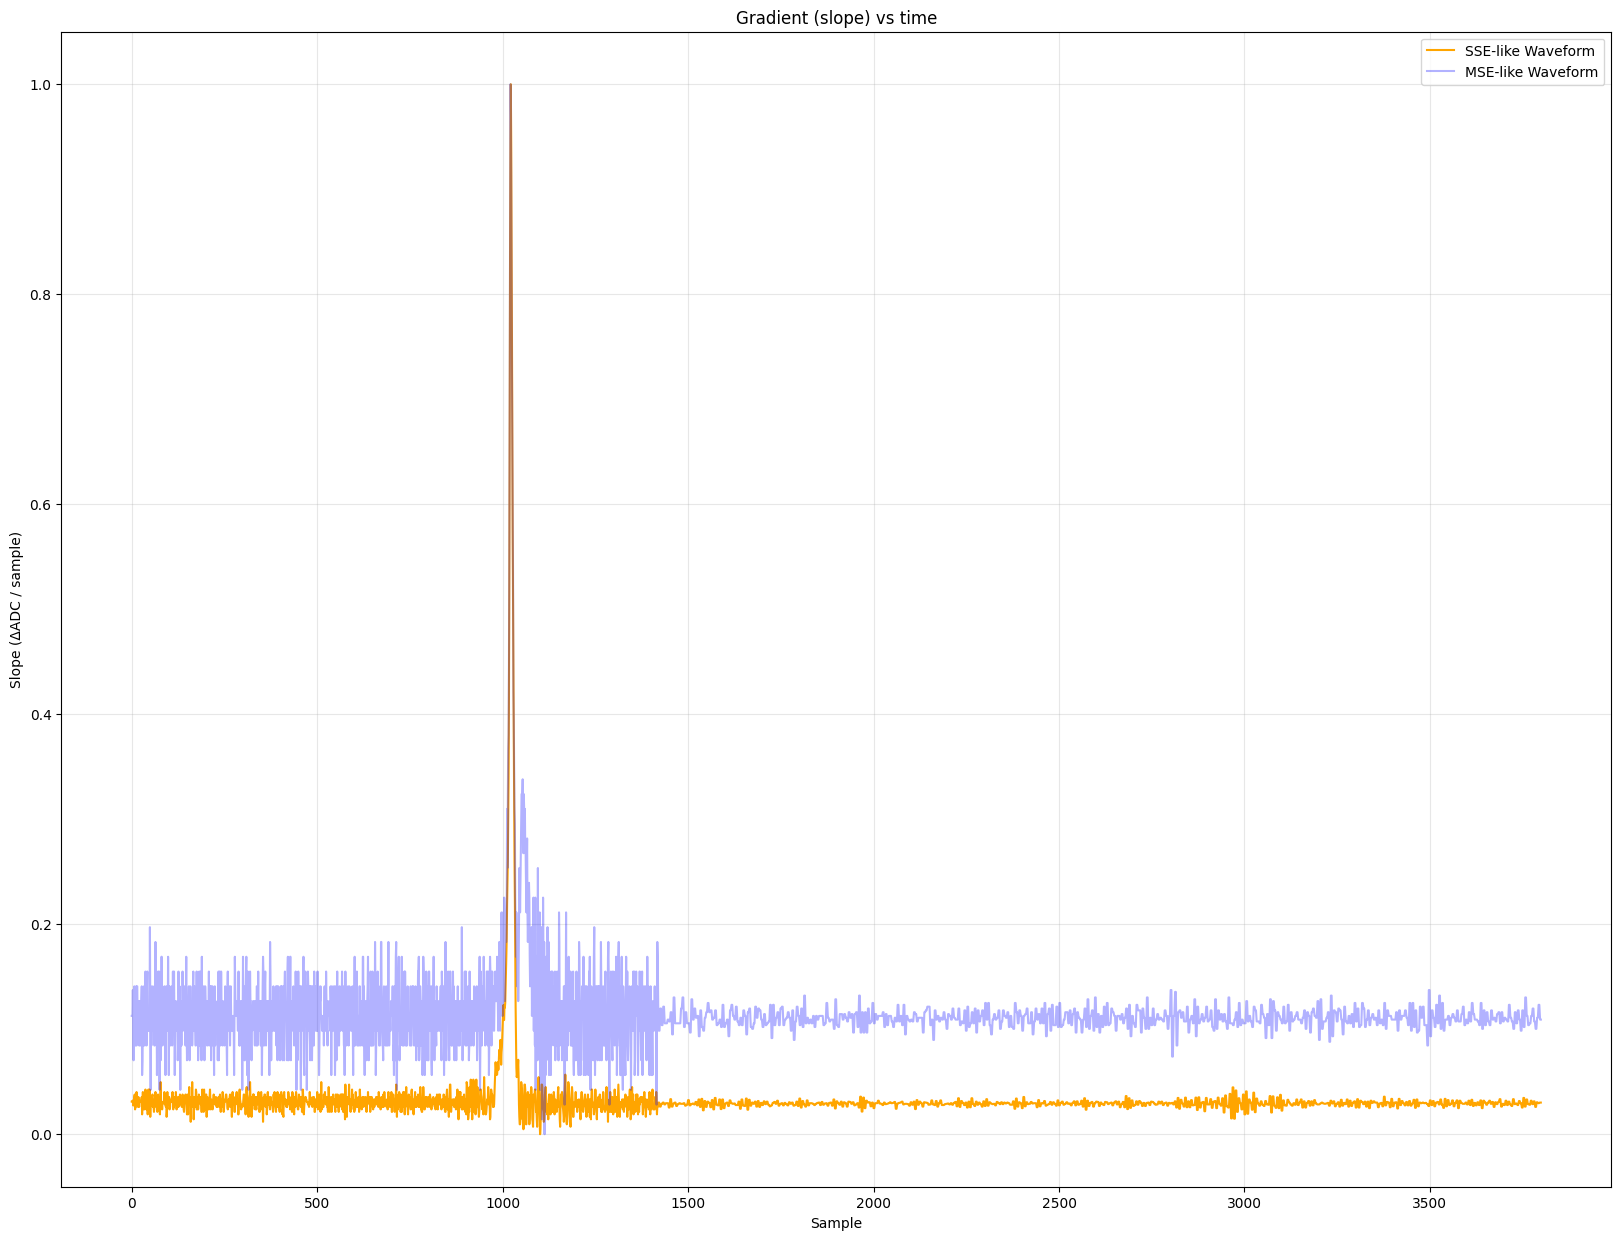

0.003225219068417155
0.44969262068871674


In [64]:
def compare_transforms(wf_sse, wf_mse, time_index, smooth_sigma=1.0):
    # ---------- 2) Gradient (slope) ----------
    g_sse, stats_sse = gradient_trace(true_waveform)
    g_mse, stats_mse = gradient_trace(false_waveform)

    wf_norm_sse = (g_sse - np.min(g_sse)) / (np.max(g_sse) - np.min(g_sse))
    wf_norm_mse = (g_mse - np.min(g_mse)) / (np.max(g_mse) - np.min(g_mse))

    plt.figure(figsize=(20, 15))
    plt.plot(time_index, wf_norm_sse, label='SSE-like Waveform', color='orange')
    plt.plot(time_index, wf_norm_mse, label='MSE-like Waveform', color='blue', alpha = 0.3)  
    plt.title("Gradient (slope) vs time")
    plt.xlabel("Sample")
    plt.ylabel("Slope (ΔADC / sample)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(wf_norm_sse[1200:].std())
    print(g_mse[1200:].std())

compare_transforms(true_waveform, false_waveform, time_index)